# Getting started with ReColorAdv
This file contains instructions for experimenting with the ReColorAdv attack, by itself and combined with other attacks. This tutorial is based on the [first tutorial](https://github.com/revbucket/mister_ed/blob/master/notebooks/tutorial_1.ipynb) of `mister_ed`. See the README to make sure all dependencies are installed.

## Imports
First let's make sure that you can import everything you need:

In [1]:
# EXTERNAL LIBRARIES
import numpy as np 
import re

import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision

In [2]:
# mister_ed
import recoloradv.mister_ed.loss_functions as lf 
import recoloradv.mister_ed.utils.pytorch_utils as utils
import recoloradv.mister_ed.utils.image_utils as img_utils
import recoloradv.mister_ed.cifar10.cifar_loader as cifar_loader
import recoloradv.mister_ed.cifar10.cifar_resnets as cifar_resnets
import recoloradv.mister_ed.adversarial_training as advtrain
import recoloradv.mister_ed.utils.checkpoints as checkpoints
import recoloradv.mister_ed.adversarial_perturbations as ap 
import recoloradv.mister_ed.adversarial_attacks as aa
import recoloradv.mister_ed.spatial_transformers as st
import recoloradv.mister_ed.config as config

# ReColorAdv
import recoloradv.perturbations as pt
import recoloradv.color_transformers as ct
import recoloradv.color_spaces as cs
from recoloradv import norms
from recoloradv.utils import load_pretrained_cifar10_model, get_attack_from_name

#  Generating adversarial examples

Here, we will demonstrate how to generate a single minibatch of adversarial examples using ReColorAdv on CIFAR-10.


To set up, let's start by collecting a minibatch worth of data and loading up our classifier to attack.

In [3]:
from PIL import Image

In [4]:
im = Image.open("../Spatial_transform/ST_ADV_exp_imagenet/sample_imagenet/sample_0.jpg")
examples = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(im)))
examples = examples.unsqueeze(0)
labels = torch.tensor([17])

model = torchvision.models.vgg16(pretrained=True)
normalizer = utils.DifferentiableNormalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

if utils.use_gpu():
    examples = examples.cuda()
    labels = labels.cuda() 
    model.cuda()

In [5]:
# cifar_valset = cifar_loader.load_cifar_data('val', batch_size=4)
# examples, labels = next(iter(cifar_valset))

# model, normalizer = load_pretrained_cifar10_model('pretrained_models/normal.resnet32.pt')

# if utils.use_gpu():
#     examples = examples.cuda()
#     labels = labels.cuda() 
#     model.cuda()

Let's take a look at what our original images look like:

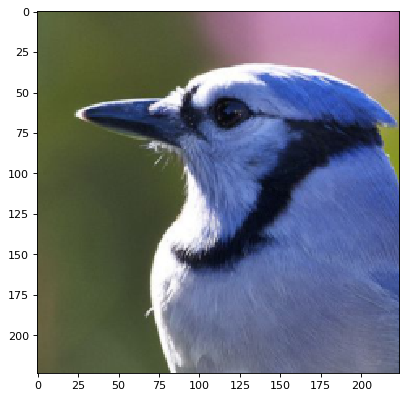

In [6]:
img_utils.show_images(examples, figsize=(6,6))

## ReColorAdv
Now let's attack all of these examples with a ReColorAdv attack that changes every pixel using the same function.

(START):  100.0 correct
(iteration 00):  100.0 correct
(iteration 01):  100.0 correct
(iteration 02):  100.0 correct
(iteration 03):  100.0 correct
(iteration 04):  100.0 correct
(iteration 05):  100.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct


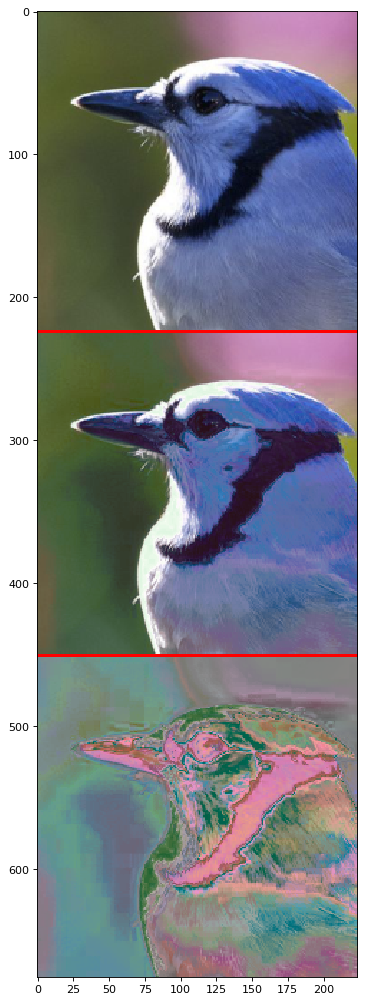

In [7]:
# This threat model defines the regularization parameters of the attack.
recoloradv_threat = ap.ThreatModel(pt.ReColorAdv, {
    'xform_class': ct.FullSpatial, 
    'cspace': cs.CIELUVColorSpace(), # controls the color space used
    'lp_style': 'inf',
    'lp_bound': [0.06, 0.06, 0.06],  # [epsilon_1, epsilon_2, epsilon_3]
    'xform_params': {
      'resolution_x': 16,            # R_1
      'resolution_y': 32,            # R_2
      'resolution_z': 32,            # R_3
    },
    'use_smooth_loss': True,
})


# Now, we define the main optimization term (the Carlini & Wagner f6 loss).
adv_loss = lf.CWLossF6(model, normalizer)

# We also need the smoothness loss.
smooth_loss = lf.PerturbationNormLoss(lp=2)

# We combine them with a RegularizedLoss object.
attack_loss = lf.RegularizedLoss({'adv': adv_loss, 'smooth': smooth_loss}, 
                                 {'adv': 1.0,      'smooth': 0.05},   # lambda = 0.05
                                 negate=True) # Need this true for PGD type attacks

# PGD is used to optimize the above loss.
pgd_attack_obj = aa.PGD(model, normalizer, recoloradv_threat, attack_loss)

# We run the attack for 10 iterations at learning rate 0.01.
perturbation = pgd_attack_obj.attack(examples, labels, num_iterations=10, signed=False, 
                                     optimizer=optim.Adam, optimizer_kwargs={'lr': 0.01},
                                     verbose=True)

# Now, we can collect the successful adversarial examples and display them.
successful_advs, successful_origs = perturbation.collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 3 + 0.5).clamp(0, 1)
img_utils.show_images([successful_origs, successful_advs, successful_diffs])

In the above image, the first row is the original images; the second row is the adversarial examples; and the third row is the magnified difference between them.

## Combined Attacks
Now that we've seen how to use the ReColorAdv attack, we can combine it with an additive delta attack.

(START):  100.0 correct
(iteration 00):  0.0 correct
(iteration 01):  0.0 correct
(iteration 02):  0.0 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct


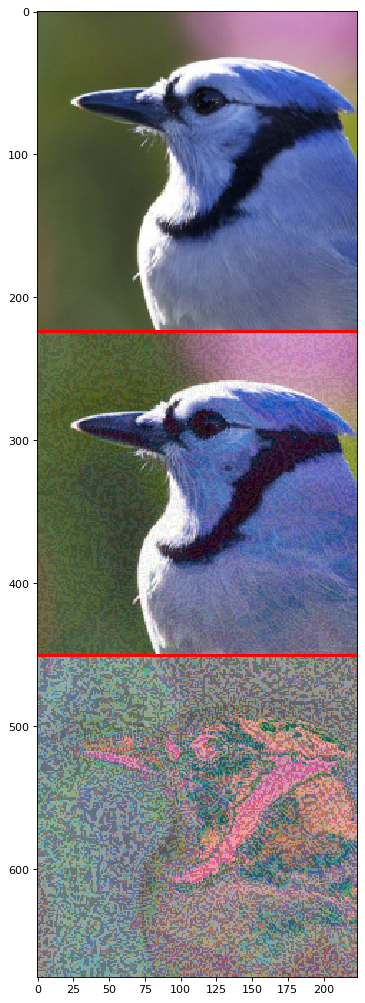

In [23]:
# First, we define the additive threat model.
additive_threat = ap.ThreatModel(ap.DeltaAddition, {
   'lp_style': 'inf', 
   'lp_bound': 0.03,
})

# Combine it with the ReColorAdv functional threat model.
combined_threat = ap.ThreatModel(
    ap.SequentialPerturbation, 
    [recoloradv_threat, additive_threat],
    ap.PerturbationParameters(norm_weights=[1.0, 0.0]),
)

# Again, define the optimization terms.
adv_loss = lf.CWLossF6(model, normalizer)
smooth_loss = lf.PerturbationNormLoss(lp=2)
attack_loss = lf.RegularizedLoss({'adv': adv_loss, 'smooth': smooth_loss}, 
                                 {'adv': 1.0,      'smooth': 0.05},
                                 negate=True) # Need this true for PGD type attacks

# Setup and run PGD over both perturbations at once.
pgd_attack_obj = aa.PGD(model, normalizer, combined_threat, attack_loss)
perturbation = pgd_attack_obj.attack(examples, labels, num_iterations=10, signed=False, 
                                     optimizer=optim.Adam, optimizer_kwargs={'lr': 0.01},
                                     verbose=True)

# Display the successful adversarial examples.
successful_advs, successful_origs = perturbation.collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 3 + 0.5).clamp(0, 1)
img_utils.show_images([successful_origs, successful_advs, successful_diffs])

Note that the resulting adversarial examples have been both recolored using ReColorAdv and had some additive adversarial noise applied from the delta attack.

## Prebuilt Attacks
The convenience function `get_attack_from_name` allows you to easily instantiate one of the attacks used in the paper. For instance, to use the combined ReColorAdv, StAdv, and delta attacks:

(START):  100.0 correct
(iteration 00):  0.0 correct
(iteration 01):  0.0 correct
(iteration 02):  0.0 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct
(iteration 10):  0.0 correct
(iteration 11):  0.0 correct
(iteration 12):  0.0 correct
(iteration 13):  0.0 correct
(iteration 14):  0.0 correct
(iteration 15):  0.0 correct
(iteration 16):  0.0 correct
(iteration 17):  0.0 correct
(iteration 18):  0.0 correct
(iteration 19):  0.0 correct
(iteration 20):  0.0 correct
(iteration 21):  0.0 correct
(iteration 22):  0.0 correct
(iteration 23):  0.0 correct
(iteration 24):  0.0 correct
(iteration 25):  0.0 correct
(iteration 26):  0.0 correct
(iteration 27):  0.0 correct
(iteration 28):  0.0 correct
(iteration 29):  0.0 correct
(iteration 30):  0.0 correct
(iteration 31):  0.0 correct
(iteration 32):  0.0 correct
(iteration 33):  0.

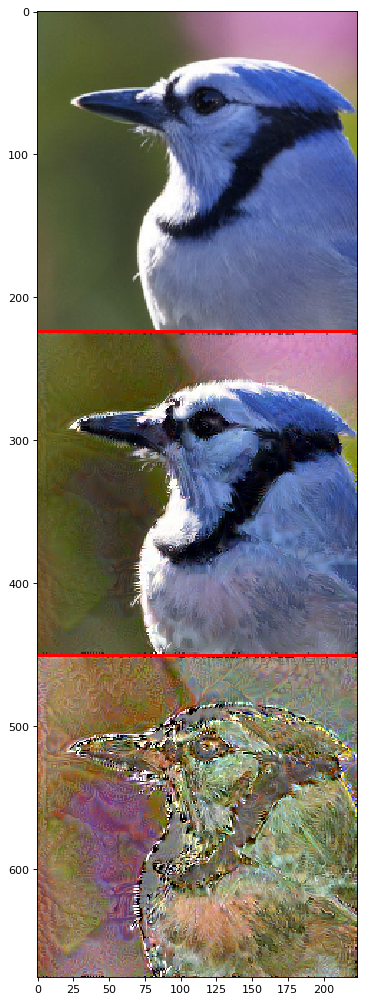

In [34]:
attack = get_attack_from_name('recoloradv+stadv+delta', model, normalizer, verbose=True)
perturbation = attack.attack(examples, labels)

# Display the successful adversarial examples.
successful_advs, successful_origs = perturbation[4].collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 3 + 0.5).clamp(0, 1)
img_utils.show_images([successful_origs, successful_advs, successful_diffs])

In [35]:
model(normalizer.forward(successful_advs)).argsort(descending=True)

tensor([[ 19,  13,  16,  20, 338,  18,  85, 309, 375,  17,  10,  15,  11,  95,
          94,  12, 380,  91,  99, 370,  14, 377,  82, 308,  86, 333, 448, 374,
         140, 139,  98, 336,  93, 310, 320, 301, 912,  92, 155, 322, 137, 696,
         749, 133, 356,  80, 804,  97, 358, 371, 134, 362, 488, 334, 388, 330,
         324,  83,  21, 284,  23, 219, 618, 378, 302, 633, 360, 136, 710, 361,
         305, 306, 387, 384, 355, 196, 240, 473, 359, 312, 567, 303,  96, 364,
         849, 883, 859, 904, 783, 164, 131, 198,   8,  87,  24, 143, 331, 307,
         304, 316, 512, 726, 381, 622, 314, 152, 162, 478,  78, 909, 335, 217,
         987, 855, 674, 103, 332, 319, 379, 157, 156,  56, 587, 138, 503, 899,
         326, 773, 558, 150, 999, 337, 383, 232, 418, 868, 382, 368, 489, 583,
         695, 357,  76, 988, 995,  75, 588, 711, 764, 584, 321, 626, 144, 212,
         784,   7, 937, 958, 176, 677,  84, 818, 204, 551, 195, 434, 161, 145,
         463, 248, 328, 506,  81, 250, 700, 589, 722